In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework import ops
from utility import load_dataset
import math

### Loading Dataset

In [2]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 1. It's a cat picture.


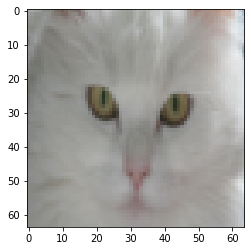

In [3]:
# Example of a picture
index = 50
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

Getting Shapes Of Data

In [4]:
print('train_x_shape :',train_x_orig.shape)
print('train_y_shape :',train_y.shape)
print('test_x_shape  :',test_x_orig.shape)
print('test_y_shape  :',test_y.shape)
print('Classes       :',classes)

train_x_shape : (209, 64, 64, 3)
train_y_shape : (1, 209)
test_x_shape  : (50, 64, 64, 3)
test_y_shape  : (1, 50)
Classes       : [b'non-cat' b'cat']


Getting Necessary Variables

In [5]:
m_train = train_x_orig.shape[0]
m_test  = test_x_orig.shape[0]
num_px  = train_x_orig.shape[1]

#### Reshaping Data

In [6]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

In [7]:
print('train_x_flatten :',train_x_flatten.shape)
print('test_x_flatten  :',test_x_flatten.shape)

train_x_flatten : (12288, 209)
test_x_flatten  : (12288, 50)


#### Standardizing Data

In [8]:
# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

###  Creating placeholders
Your first task is to create placeholders for `X` and `Y`. This will allow you to later pass your training data in when you run your session. 

In [9]:
def create_placeholders(n_x,n_y):
    
    X = tf.placeholder(tf.float32,[n_x,None],name='x')
    Y = tf.placeholder(tf.float32,[n_y,None],name='y')
    
    return X,Y

### Initialize Parameters

In [10]:
def initialize(layer_dims):
    parameters={}
    L = len(layer_dims)
    
    for l in range(L-1):
        parameters['W'+str(l+1)] = tf.get_variable('W'+str(l+1),[layer_dims[l+1],layer_dims[l]],initializer = tf.contrib.layers.xavier_initializer(seed=1))
        parameters['b'+str(l+1)] = tf.get_variable('b'+str(l+1),[layer_dims[l+1],1],initializer = tf.zeros_initializer())
        
    return parameters

In [11]:
tf.reset_default_graph()
parameters = initialize([2,4,3])
print(parameters)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

{'W1': <tf.Variable 'W1:0' shape=(4, 2) dtype=float32_ref>, 'b1': <tf.Variable 'b1:0' shape=(4, 1) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(3, 4) dtype=float32_ref>, 'b2': <tf.Variable 'b2:0' shape=(3, 1) dtype=float32_ref>}


### Forward Propagation

In [12]:
def forward_prop(X,parameters):
    A = X
    L = len(parameters)//2
    
    for l in range(1,L):
        A_prev = A
        Z = tf.matmul(parameters['W'+str(l)],A_prev)+parameters['b'+str(l)]
        A = tf.nn.relu(Z)
    ## final step
    ZL = tf.matmul(parameters['W'+str(L)],A)+parameters['b'+str(L)]
    
    return ZL

In [13]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(2, 1)
    parameters = initialize([2,3,1])
    ZL = forward_prop(X, parameters)
    print("ZL = " + str(ZL))

ZL = Tensor("add_1:0", shape=(1, ?), dtype=float32)


### Compute Cost

In [14]:
def compute_cost(ZL,Y):
    
    logits = tf.transpose(ZL)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=labels))
    
    return cost

In [15]:
tf.reset_default_graph()

with tf.Session() as sess:
    X, Y = create_placeholders(2, 1)
    parameters = initialize([2,3,1])
    ZL = forward_prop(X, parameters)
    cost = compute_cost(ZL, Y)
    print("cost = " + str(cost))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
cost = Tensor("Mean:0", shape=(), dtype=float32)


### Backprop   Using  Batch Gradient Descent

In [16]:
def model(X_train,Y_train,layers_dims,learning_rate,iterations):
    
    ops.reset_default_graph()
    n_x = layers_dims[0]
    n_y = 1                   #We know it is layers_dims[-1]; but we know we are doing binary classification
    
    X, Y = create_placeholders(n_x,n_y)
    
    parameters = initialize(layers_dims)
    
    ZL = forward_prop(X,parameters)
    
    cost = compute_cost(ZL,Y)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        #run initialization
        sess.run(init)
        
        for i in range(iterations):
            sess.run([optimizer, cost], feed_dict={X: X_train, Y: Y_train})
            
        # lets save the parameters in a variable
        parameters = sess.run(parameters)
    
    return parameters

In [17]:
import time

In [18]:
# Architecture
layer_dims = [12288,20,7,5,1]

In [19]:
tic = time.time()
final_parameters = model(train_x,train_y,layer_dims,learning_rate=0.0075,iterations=2500)
toc = time.time()

print('Training time : ',toc-tic,'seconds')

Training time :  50.96633839607239 seconds


### Getting Y the prediction

In [20]:
def forward_prop_test(X,parameters):
    params = {}
    
    L = len(parameters)//2
    for l in range(1,L+1):
        params['W'+str(l)] = tf.convert_to_tensor(parameters['W'+str(l)])
        params['b'+str(l)] = tf.convert_to_tensor(parameters['b'+str(l)])
    
    x = tf.placeholder("float", [12288, None])
    
    zL = forward_prop(x,params)
    AL = tf.sigmoid(zL)
    sess = tf.Session()
    Y = sess.run(AL,feed_dict={x:X})
    sess.close()
    return Y

In [21]:
Y = forward_prop_test(test_x,final_parameters)
print(Y)

[[9.8926282e-01 9.8571360e-01 9.2852020e-01 9.9718505e-01 8.5030955e-01
  9.9166512e-01 1.3314760e-01 9.3556482e-01 9.9866164e-01 9.9939120e-01
  9.9996996e-01 9.9996942e-01 9.9989820e-01 9.9999619e-01 4.3630600e-05
  9.9960864e-01 1.3322830e-03 9.9596572e-01 7.0393085e-04 9.1254711e-05
  9.7731543e-01 6.7555904e-04 9.8347664e-06 9.7640371e-01 9.4353426e-01
  9.9998534e-01 8.6967075e-01 8.1200600e-03 2.7394381e-01 9.9999899e-01
  9.9914956e-01 9.9999988e-01 9.3315655e-01 8.2634276e-01 3.3856696e-01
  1.2814999e-06 8.2234442e-03 9.0234804e-01 5.2032650e-01 1.4907131e-01
  6.3616496e-01 8.1015873e-01 9.8474985e-01 2.2895932e-03 9.9933892e-01
  1.4272133e-01 1.5361309e-03 9.9997973e-01 1.7792930e-01 2.7518440e-04]]


- Above we have got the probability of each image; if it is a cat or not.
- It is better to round them off
- Threshold = 0.5;

In [22]:
for i in range(50):
    if(Y[0][i]>0.5):
        Y[0][i]=1
    else:
        Y[0][i]=0
print(Y)

[[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1.
  0. 0.]]


In [23]:
print(test_y)

[[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]


In [24]:
c = 0
for i in range(50):
    if(Y[0][i]==test_y[0][i]):
        c+=1
print('Accuracy :' ,(c/50)*100,'%')

Accuracy : 78.0 %


#### Let Us Try to code it down using Adam Optimizer

First we define a Function that creates Minibatches

In [25]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [26]:
def Adam_model(X_train,Y_train,layers_dims,learning_rate,minibatch_size,epochs):
    
    ops.reset_default_graph()
    n_x = layers_dims[0]
    n_y = 1 
    seed = 1
    m = m_train
    
    X, Y = create_placeholders(n_x,n_y)
    
    parameters = initialize(layers_dims)
    
    ZL = forward_prop(X,parameters)
    
    cost = compute_cost(ZL,Y)
    
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        
        sess.run(init)
        
        for i in range(epochs):
            num_minibatches = int(m / minibatch_size)
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                
        parameters = sess.run(parameters)
        
    return parameters

In [27]:
tic = time.time()
final_adam_parameters = Adam_model(train_x,train_y,layer_dims,learning_rate=0.0075,minibatch_size=32,epochs=100)
toc = time.time()

print('Training time : ',toc-tic,'seconds')

Training time :  4.136263132095337 seconds


In [28]:
Y = forward_prop_test(test_x,final_adam_parameters)
print(Y)

[[7.8843981e-01 7.8843981e-01 7.8843981e-01 7.8843981e-01 7.8843981e-01
  7.8843981e-01 8.7669492e-04 7.8843981e-01 7.8843981e-01 7.8843981e-01
  7.8843981e-01 7.8843981e-01 7.8843981e-01 7.8843981e-01 3.0270219e-04
  7.8843981e-01 7.6246262e-04 7.8843981e-01 7.8843981e-01 3.6030173e-02
  7.8843981e-01 3.2552767e-01 3.6045909e-04 7.8843981e-01 7.8843981e-01
  7.8843981e-01 7.8843981e-01 2.1427870e-05 3.8360387e-02 7.8843981e-01
  2.6691675e-02 7.8843981e-01 7.8843981e-01 7.8843981e-01 7.8843981e-01
  1.5901107e-01 8.1848204e-02 7.8843981e-01 6.7481494e-01 2.3591828e-01
  7.8843981e-01 7.8843981e-01 7.8843981e-01 4.0933192e-03 7.8843981e-01
  7.3403251e-01 3.0332255e-01 7.8843981e-01 7.8843975e-01 2.5848856e-02]]


In [29]:
for i in range(50):
    if(Y[0][i]>0.5):
        Y[0][i]=1
    else:
        Y[0][i]=0
print(Y)

[[1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1.
  1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1.
  1. 0.]]


In [30]:
c = 0
for i in range(50):
    if(Y[0][i]==test_y[0][i]):
        c+=1
print('Accuracy :' ,(c/50)*100,'%')

Accuracy : 76.0 %


#### Right now I have Just tuned the parameters;  we can clearly see that using Adam Optimizer we can get Our model Trained approx 16 times faster!! with acuraccy somewhat near to it